<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, f1_score, roc_auc_score, roc_curve, \
classification_report, confusion_matrix, balanced_accuracy_score, precision_score, recall_score, fbeta_score, \
plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from itertools import combinations
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
# 1) Посмотрите на случайные строчки.

temp_df = pd.DataFrame()
for row in range(5):
    temp_df = temp_df.append(data.iloc[random.choice(data.index)])
temp_df

,Churn,ClientPeriod,HasChild,HasContractPhone,HasDeviceProtection,HasInternetService,HasMovieSubscription,HasMultiplePhoneNumbers,HasOnlineBackup,HasOnlineSecurityService,HasOnlineTV,HasPartner,HasPhoneService,HasTechSupportAccess,IsBillingPaperless,IsSeniorCitizen,MonthlySpending,PaymentMethod,Sex,TotalSpent
1893,1.0,65.0,No,Month-to-month,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,0.0,91.85,Bank transfer (automatic),Male,5940.85
3271,0.0,66.0,No,Two year,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,0.0,85.25,Electronic check,Male,5538.35
1869,0.0,40.0,No,Month-to-month,No,DSL,No,No,Yes,Yes,Yes,No,Yes,No,No,0.0,65.10,Mailed check,Female,2586
2255,0.0,71.0,Yes,Two year,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,0.0,109.30,Credit card (automatic),Male,7782.85
1811,0.0,54.0,Yes,Two year,No,DSL,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,0.0,65.65,Credit card (automatic),Male,3566.7


In [12]:
#или так
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5073,60.0,50.05,2911.5,Female,0,Yes,No,No,No phone service,DSL,Yes,Yes,Yes,No,No,Yes,One year,No,Electronic check,0
2895,1.0,44.90,44.9,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
1984,61.0,69.90,4226.7,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Mailed check,0
1653,11.0,19.50,226.8,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1166,59.0,34.80,1980.3,Male,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,0


In [19]:
import inspect
print(inspect.getdoc(random.sample))
print(inspect.getsource(random.sample))

Chooses k unique random elements from a population sequence or set.

Returns a new list containing elements from the population while
leaving the original population unchanged.  The resulting list is
in selection order so that all sub-slices will also be valid random
samples.  This allows raffle winners (the sample) to be partitioned
into grand prize and second place winners (the subslices).

Members of the population need not be hashable or unique.  If the
population contains repeats, then each occurrence is a possible
selection in the sample.

To choose a sample in a range of integers, use range as an argument.
This is especially fast and space efficient for sampling from a
large population:   sample(range(10000000), 60)
    def sample(self, population, k):
        """Chooses k unique random elements from a population sequence or set.

        Returns a new list containing elements from the population while
        leaving the original population unchanged.  The resulting list is
   

In [4]:
# Приведем категориальные признаки к нужному типу данных.
data[cat_cols] = data[cat_cols].astype('category')
data[target_col] = data[target_col].astype('category')

# TotalSpent имеет тип object. Приведём его к числовому типу.
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
data[num_cols] = data[num_cols].astype('float')

# Теперь у нас все признаки приведены к нужным типам. Можно дальше исследовать данные.
data.dtypes

ClientPeriod                 float64
MonthlySpending              float64
TotalSpent                   float64
Sex                         category
IsSeniorCitizen             category
HasPartner                  category
HasChild                    category
HasPhoneService             category
HasMultiplePhoneNumbers     category
HasInternetService          category
HasOnlineSecurityService    category
HasOnlineBackup             category
HasDeviceProtection         category
HasTechSupportAccess        category
HasOnlineTV                 category
HasMovieSubscription        category
HasContractPhone            category
IsBillingPaperless          category
PaymentMethod               category
Churn                       category
dtype: object

In [5]:
# 2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() 
# или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите 
# табличку с количеством nan в каждой колонке.

if sum(list(data.isna().sum())) == 0:
    print('NaN-строки отсутствуют')
else:
    print(f'NaN-строки присутствуют в количестве:\n\n{data.isna().sum()}')

NaN-строки присутствуют в количестве:

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


In [7]:
# В столбце TotalSpent есть пропущенные значения, посмотрим на эти строки внимательнее
data[data['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0.0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0.0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0.0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0.0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0.0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0.0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0.0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0.0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0.0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


**У всех 9 пользователей ClientPeriod = 0 , значит они еще ни разу вносили плату. <br>В таком случае можно заполнить пропущенные значения нулями.**

In [6]:
# Заполняем нулями пропущенные значения.
data['TotalSpent'].fillna(0, inplace=True)
print('Пропущенных значений в TotalSpent: ', data['TotalSpent'].isna().sum(), sep='')

Пропущенных значений в TotalSpent: 0


### Общие характеристики датасета

In [10]:
from io import StringIO
import sys


class OutputInterceptor(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


with OutputInterceptor() as output:
    data.info(verbose=False)
row = int(''.join(output).split()[2])
print('В датасете:', ''.join(output).split()[
      2], 'строк,', ''.join(output).split()[7], 'столбцов')

В датасете: 5282 строк, 20 столбцов


In [10]:
print('Перечень столбцов:\n',', '.join(list(data)))

Перечень столбцов:
 ClientPeriod, MonthlySpending, TotalSpent, Sex, IsSeniorCitizen, HasPartner, HasChild, HasPhoneService, HasMultiplePhoneNumbers, HasInternetService, HasOnlineSecurityService, HasOnlineBackup, HasDeviceProtection, HasTechSupportAccess, HasOnlineTV, HasMovieSubscription, HasContractPhone, IsBillingPaperless, PaymentMethod, Churn


## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

#### Посмотрим сначала на наши числовые данные. Это признаки ClientPeriod, MonthlySpending и TotalSpent

Способ 1. Seaborn, histplot

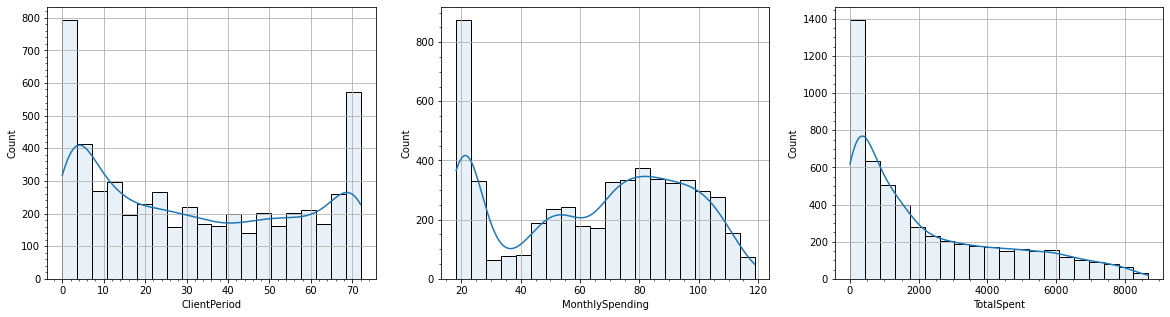

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
counter = 0
for name in data[['ClientPeriod', 'MonthlySpending', 'TotalSpent']]:
    sns.histplot(data[name], kde=True, bins=20,
                 ax=ax[counter], label=name, alpha=0.1)
    ax[counter].minorticks_on()
    ax[counter].grid()
    counter += 1

Способ 2. Matplotlib, hist

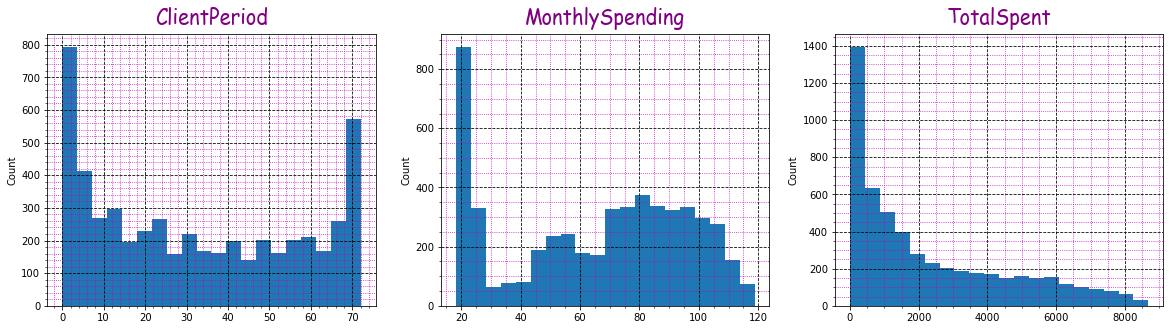

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
counter = 0
for name in data[['ClientPeriod', 'MonthlySpending', 'TotalSpent']]:
    ax[counter].set_title(name, fontfamily='fantasy', fontstyle='italic',
                          color='purple', fontsize=20, pad=10)
    ax[counter].hist(data[name], bins=20)
    ax[counter].grid(which='major', color='k', linestyle='--')
    ax[counter].minorticks_on()
    ax[counter].grid(which='minor', color='m', linestyle=':')
    counter += 1

plt.setp(ax, ylabel='Count')
plt.rcParams['axes.labelsize'] = 15
plt.show()

Способ 3. Seaborn, boxplot

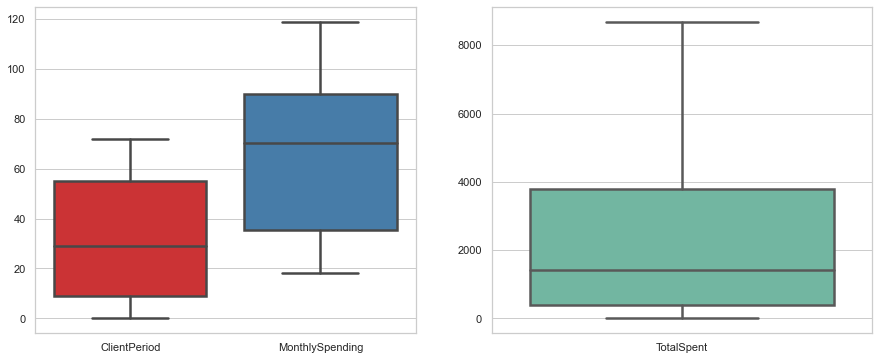

In [14]:
sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.boxplot(data=data[['ClientPeriod','MonthlySpending']], ax=ax[0], palette='Set1', linewidth=2.5)
sns.boxplot(data=data['TotalSpent'], ax=ax[1], palette='Set2', linewidth=2.5)
ax[1].set_xticklabels(['TotalSpent'])
plt.show()

***Ни одна из величин не распределена нормально, похоже что у ClientPeriod бимодальное распределение. У TotalSpent очевидная асимметрия с длинным "хвостом" справа. Но выбросов(outliers) нет, и это уже неплохо.<br><br> Нужно будет стандартизировать или нормализовать данные, попробуем несколько вариантов.***

**Теперь посмотрим на оставшиеся категориальные признаки.**

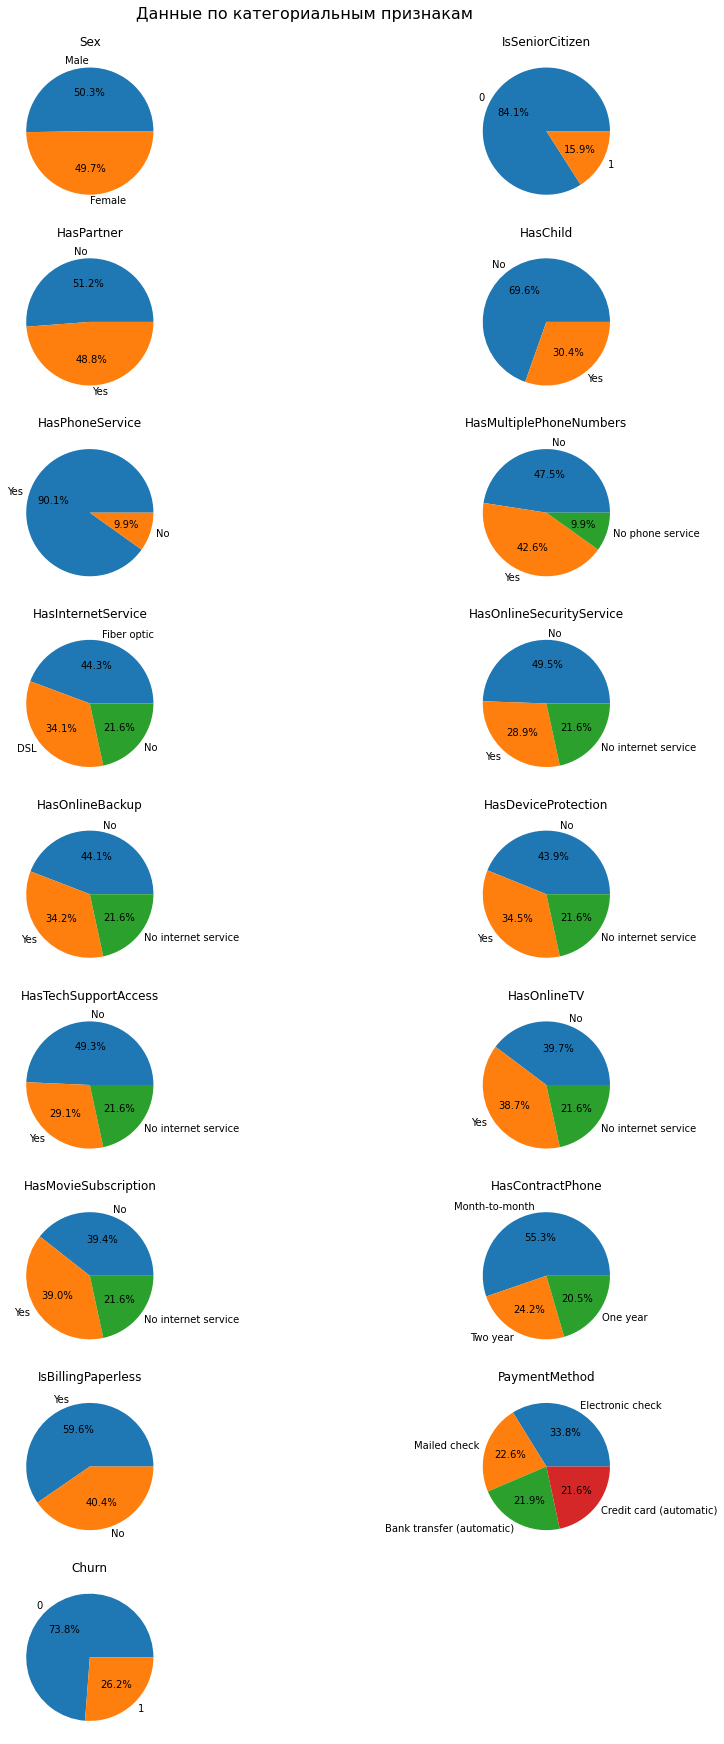

In [11]:
non_num_cols = [x for x in data.columns if x not in num_cols]

fig, ax = plt.subplots(9,2, figsize=(15,31))
counter = 0
for i in range(9):
    for j in range(2):
        df_temp=data[non_num_cols[counter]].value_counts()
        ax[i,j].pie(df_temp, autopct='%.1f%%', labels=df_temp.index)
        ax[i,j].set_title(non_num_cols[counter])
        counter += 1
        if counter > 16:
            break
ax[8,1].remove()
plt.suptitle('Данные по категориальным признакам', x=.5,y=.9, fontsize=16)
plt.show()

## И более пристально рассмотрим целевую переменную Churn

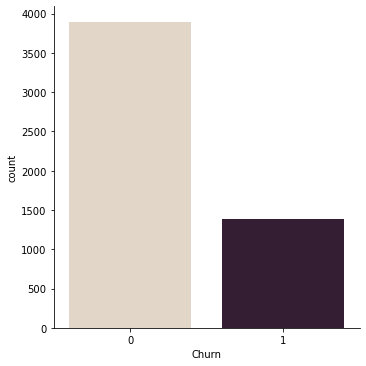

In [12]:
sns.catplot(x='Churn', kind='count', palette='ch:.25', data=data)
plt.show()

In [11]:
print(f'Разбалансировка классов в целевой переменной \
{data.Churn.value_counts()[0]}/{data.Churn.value_counts()[1]}')

Разбалансировка классов в целевой переменной 3898/1384


Глядя на эти данные можно сразу сделать несколько выводов.

1. Датасет не сбалансирован. Чуть больше четверти клиентов ушли в "отток". Это нужно будет учитывать при разбивке на тренировочную и тестовую части, а также при кросс-валидации. Необходимо будет использовать стратифицированную выборку и разные варианты овер- и андерсемплинга для балансировки датасета.
2. У признаков HasPhoneService и HasMultiplePhoneNumbers дублируется категория No phone service. Такая же картина наблюдается с признаками No internet service в признаках различных сервисов. Возможно есть смысл отдельно вытащить бинарный столбец с информацией о наличии-отсутствии интернета. Так же как сейчас у признака HasPhoneService.

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

# Исследование зависимостей и формулирование гипотез

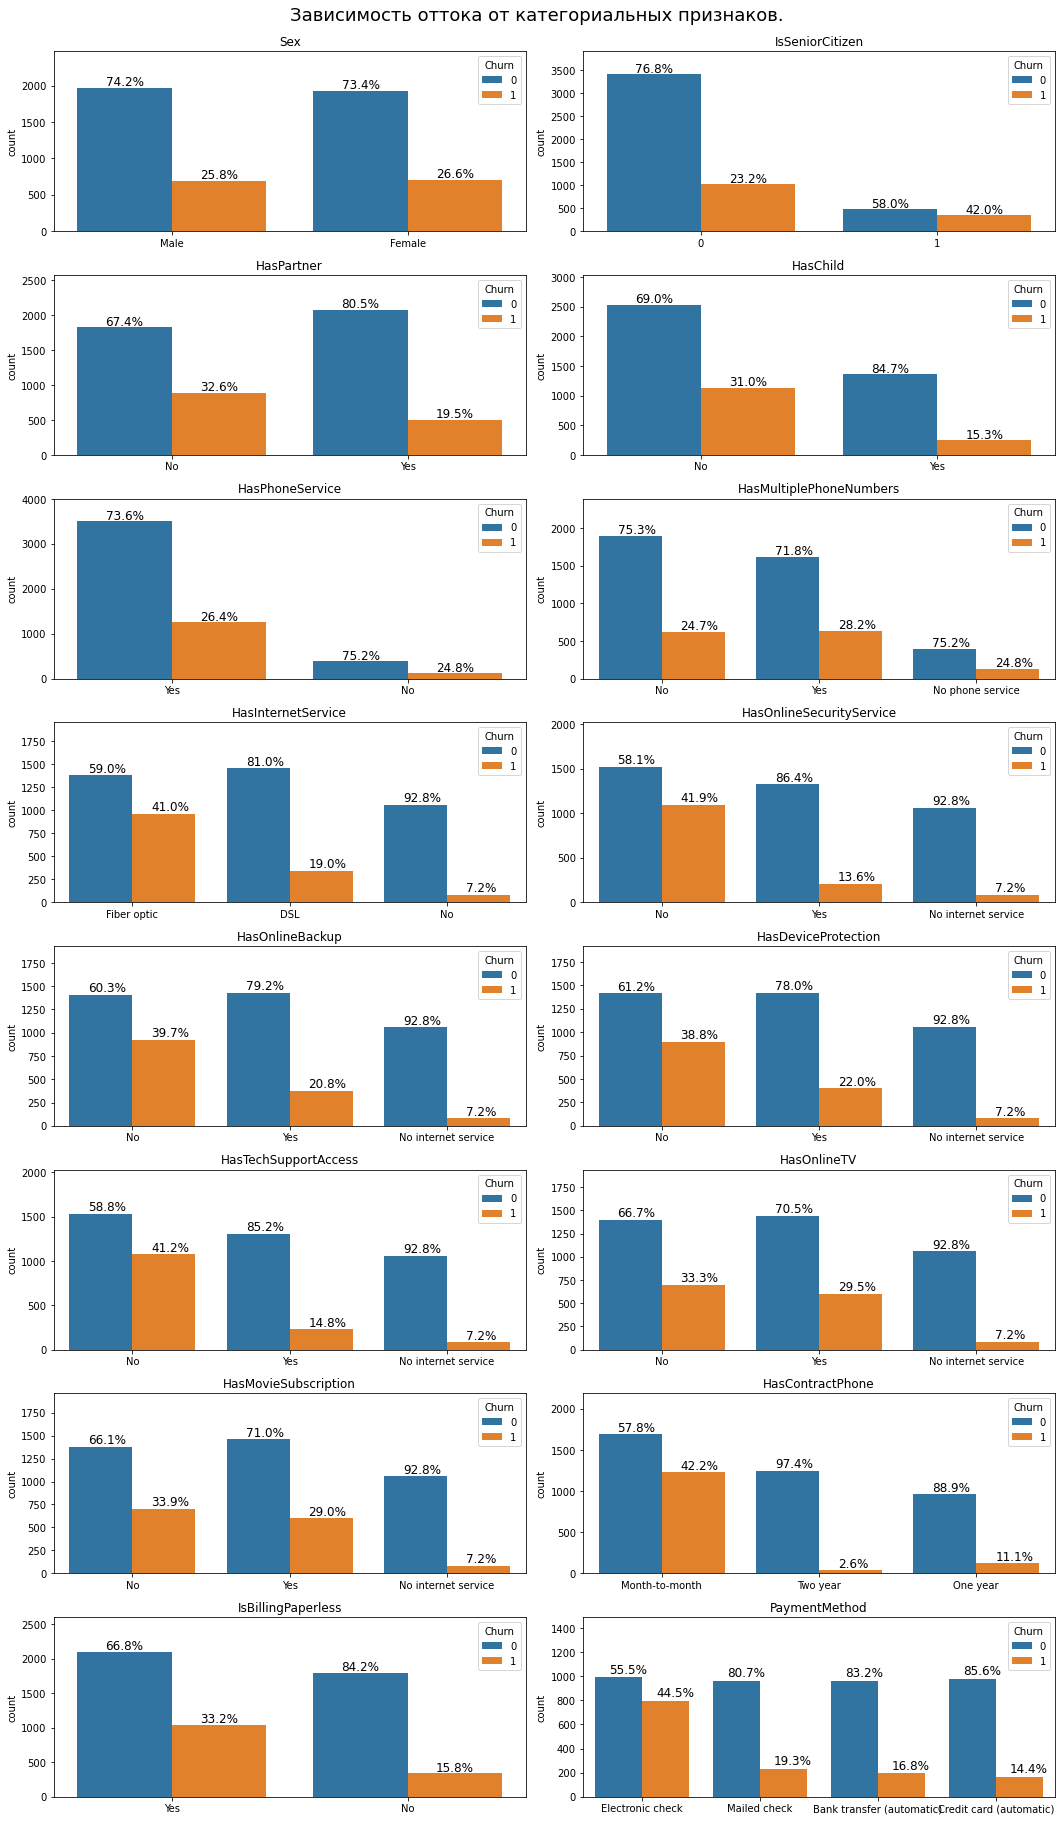

In [14]:
# Сначала посмотрим на зависимость оттока от категориальных признаков.
fig, ax = plt.subplots(8, 2, figsize=(15,25))

counter = 0
for i in range(8):
    for j in range(2):
        sns.countplot(data=data, x=cat_cols[counter], hue='Churn',
                      order=data[cat_cols[counter]].value_counts().sort_values(ascending=False).index,
                      ax=ax[i,j])
        
        heights = [p.get_height() for p in ax[i,j].patches]
        patch = [p for p in ax[i,j].patches]
        num_cat = data[cat_cols[counter]].nunique()
        
        for n in range(num_cat):
            total = data[cat_cols[counter]].value_counts().values[n]
            for m in range(2):
                percentage = '{:.1f}%'.format(100*heights[(m*num_cat + n)]/total)
                x = patch[(m*num_cat + n)].get_x() + patch[(m*num_cat + n)].get_width() / 2 - 0.08
                y = patch[(m*num_cat + n)].get_y() + patch[(m*num_cat + n)].get_height()+35
                ax[i,j].annotate(percentage, (x,y), size=12)
        
        ax[i,j].set_title(ax[i,j].get_xlabel())
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylim(0,max(heights)+500)
        counter += 1
plt.tight_layout()
plt.suptitle('Зависимость оттока от категориальных признаков.', y=1.01, fontsize=18)
plt.show()

Выводы:
1. Пол (sex): и среди мужчин, и среди женщин одинаковый процент пользователей уходит в "отток". Вероятно этот признак не даст никакой информации для моделей.
2. Пенсионеры(IsSeniorCitizen): Само респределение между пенсионерами и не пенсионерами сильно перекошено в сторону вторых. Но при этом среди пенсионеров почти вдвое выше процент ушедших в "отток" (Covid-19 ?)
3. Состоит ли в браке (HasPartner): Вполне ожидаемо, что среди людей, состоящих в браке, процент оттока существенно ниже.
4. Есть ли иждивенцы(HasChild): Тут тоже вполне ожидаемо, что у клиентов с иждивенцами процент оттока существенно ниже. Когда у людей есть определённые обязательства, они вероятно предпочитают стабильность поиску новых вариантов.
5. Есть ли телефонная связь(HasPhoneService): Процент оттока одинаковый среди обоих типов клиентов. Похоже это вообще не влияет на вероятность "оттока"
6. Несколько телефонных линий(HasMultiplePhoneNumbers): Среди тех клиентов, у кого есть телефонная связь, процент оттока очень близкий и среди клиентов использующих одну телефонную линию и среди тех, кто использует только одну линию.
7. Тип интернета(HasInternetService): Самый низкий процент оттока среди тех клиентов, которы не пользуются интернетом вообще. А вот среди тех, кто пользуется - у клиентов на "оптоволокне" процент оттока значительно выше, чем у клиентов с ADSL.
8. Дополнительные сервисы, большая часть (HasOnlineSecurityService, HasOnlineBackup, HasDeviceProtection, HasTechSupportAccess): Картина для всех сервисов похожая. Самый большой процент оттока у тех клиентов, у которых интернет подключён, но они по каким-то причинам конкретным сервисом не пользуются. Среди тех, у кого вообще услуги интернета не подключено - процент оттока значительно меньше.
9. Дополнительные сервисы, стриминговые услуги(HasOnlineTV, HasMovieSubscription): Тут довольно похожий процент оттока, середи тех кто пользуется сервисом, и среди тех, кто не пользуется.
10. Тип контракта(HasContractPhone): Всё также вполне ожидаемо, что наибольший процент оттока, среди тех клиентов, кто оплачивает услуги помесячно. Туда явно входят и новые клиенты. И конечно среди тех, кто сразу на долгое время контракт подписал отток существенно меньше. Причем с увеличением срока контракта - процент оттока уменьшается.
11. Услуга безбумажного биллинга(IsBillingPaperless): Процент оттока вдвое выше среди тех, кто пользуется этой услугой. Возможно стоит проверить сколько SeniorCitizen пользуется этой услугой.
12. Метод оплаты(PaymentMethod): Процент оттока существенно выше среди тех, кто осуществляет оплату электронным чеком. Остальные категории имеют довольно близки процент оттока.

**Теперь посмотрим на зависимости оттока от числовых признаков**<br>Тут еще сразу сразу можно проверить зависят ли как-нибудь MonthlySpending и ClientPeriod от TotalSpent.

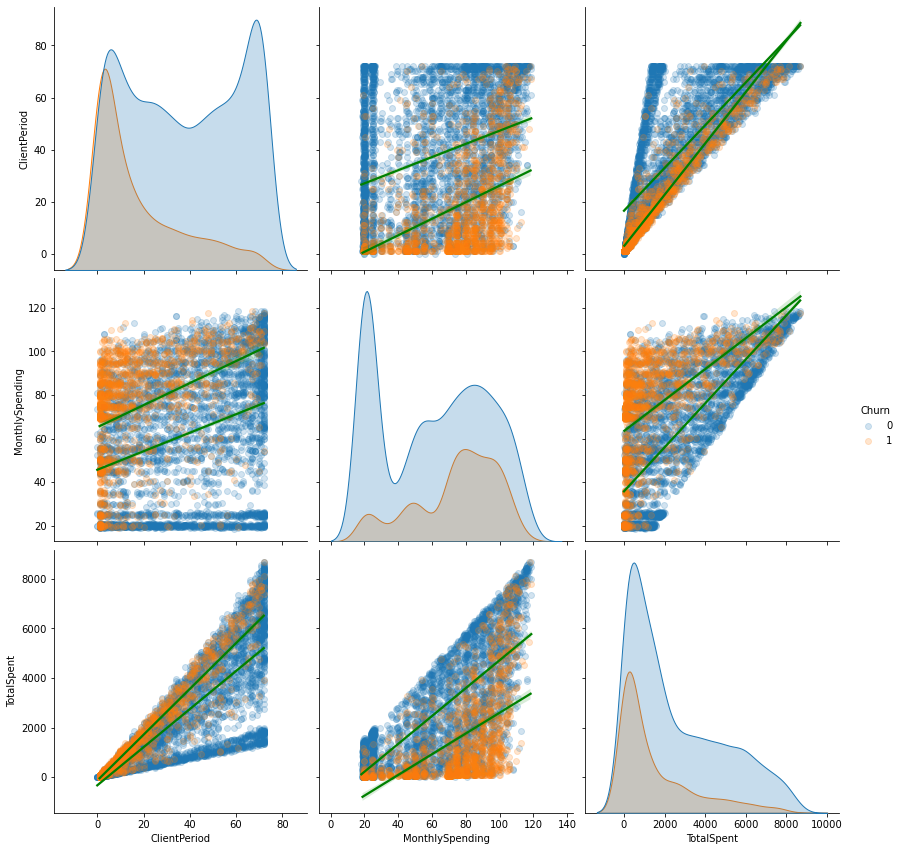

In [15]:
name_list = ['ClientPeriod','MonthlySpending','TotalSpent', 'Churn']
sns.pairplot(data[name_list], hue='Churn', kind='reg', diag_kind='kde',
             plot_kws={'scatter_kws':{'alpha':0.2},'line_kws':{'color':'green'}}, height=4)

1. Зависимость оттока от ClientPeriod, MonthlySpending, TotalSpent - нелинейная.
2. Очевидно есть корреляция между парами (ClientPeriod,MonthlySpending) и (ClientPeriod, TotalSpent)

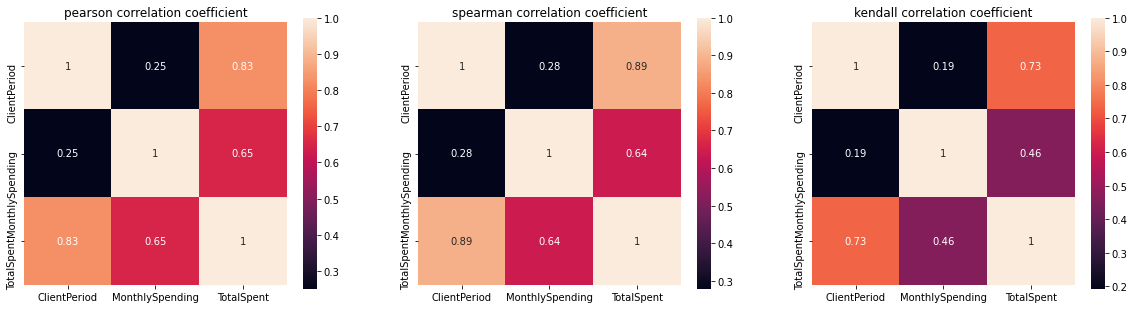

In [16]:
# Посмотрим на корреляцию этих признаков.
name_list = ['ClientPeriod','MonthlySpending','TotalSpent']
plt.figure(figsize=(20,5))
for num,name in enumerate(['pearson','spearman','kendall']):
    ax = plt.subplot(1,3,num+1)
    sns.heatmap(data[name_list].corr(method=name), annot=True, square=True, ax=ax)
    plt.title(name+' correlation coefficient')

**TotalSpent заметно(по шкале Чеддока) коррелирует с MonthlySpending и ClientPeriod. Логично было бы предположить, что это вообще произведение количества месяцев в компании на месячный платеж, с мелкими отклонениями(изменение месячного платежа при смене тарифа например)**

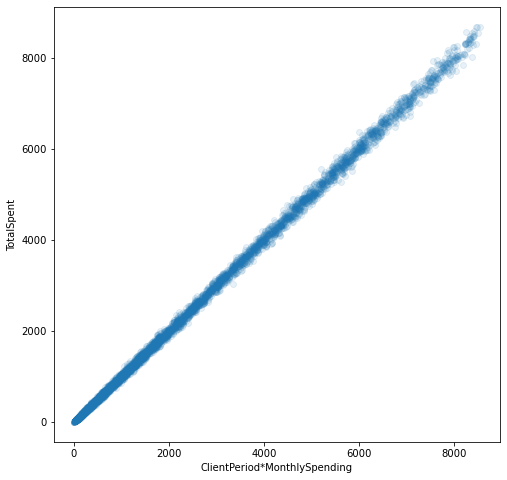

pearson correlation coefficient: 0.9995535072915908
spearman correlation coefficient: 0.9996135141794353
kendall correlation coefficient: 0.9833478448324905


In [17]:
plt.figure(figsize=(8,8))
plt.scatter(data['ClientPeriod']*data['MonthlySpending'],data['TotalSpent'], alpha=0.1)
plt.ylabel('TotalSpent')
plt.xlabel('ClientPeriod*MonthlySpending')
plt.show()
for name in ['pearson','spearman','kendall']:
    print(f'{name} correlation coefficient: {data["TotalSpent"].corr(data["ClientPeriod"]*data["MonthlySpending"],method=name)}')

Коэффициент корреляции почти единица. Конечно TotalSpent это не прямое произведение ClientPeriod и MonthlySpending, есть небольшая вариативность.<br><br>Нельзя однозначно сказать, что TotalSpent не несёт никакой дополнительной информации.<br><br> Возможно есть смысл этот признак убрать, при обучении линейных моделей. Чтобы избежать мультиколлинеарности. <br> Хотя после нормализации он может быть и не будет оказывать сильного негативного эффекта на линейные модели.

### Features-engineering

#### Генерация дополнительных признаков, учитывая информацию из EDA.

Основные идеи:
1. Посчитать общее количество сервисов, которыми пользуется клиент и посмотреть на зависимость оттока от этого количества.
2. Выделить признак наличия или отсутствия интернета отдельно, так чтобы он был бинарный. И проверить зависимость оттока от него.

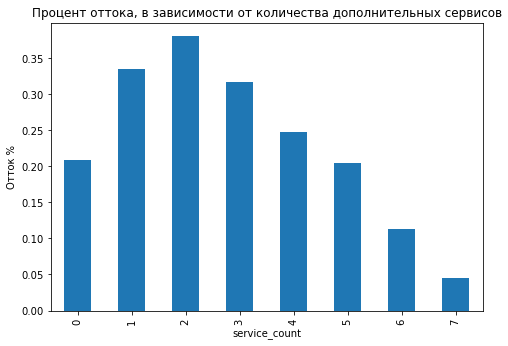

In [12]:
# Запишем в отдельный столбец количество используемых сервисов.

service_list = ['HasMultiplePhoneNumbers','HasOnlineSecurityService','HasOnlineBackup',
                'HasDeviceProtection','HasTechSupportAccess','HasOnlineTV','HasMovieSubscription']


data['service_count'] = data[service_list]\
                              .applymap(lambda x: 0 if x in ('No phone service', 'No internet service','No') else 1)\
                              .sum(axis=1)


data.groupby('service_count')['Churn'].value_counts(normalize=True).unstack()[1].plot(kind='bar',
                                                                                            ax = plt.axes((0,0,1,1)))
plt.ylabel('Отток %')
plt.title('Процент оттока, в зависимости от количества дополнительных сервисов')
plt.show()

Зависимость от количества используемых сервисов есть, и она нелинейная. Самый большой процент оттока у пользователей, подключивших 2 дополнительных сервиса. После 2 с увеличением числа сервисов - процент оттока уменьшается.

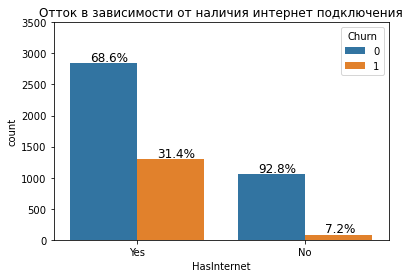

In [13]:
# Запишем в отдельный столбец наличие или отсутствие интернет подключения.
data['HasInternet'] = (data['HasInternetService'] != 'No').astype('category')
ax = sns.countplot(data=data, x='HasInternet', hue='Churn',order=data['HasInternet'].value_counts().sort_values(ascending=False).index)
heights = [p.get_height() for p in ax.patches]
patch = [p for p in ax.patches]
num_cat = 2

for n in range(num_cat):
    total = data['HasInternet'].value_counts().values[n]
    for m in range(2):
        percentage = '{:.1f}%'.format(100*heights[(m*num_cat + n)]/total)
        x = patch[(m*num_cat + n)].get_x() + patch[(m*num_cat + n)].get_width() / 2 - 0.08
        y = patch[(m*num_cat + n)].get_y() + patch[(m*num_cat + n)].get_height()+35
        ax.annotate(percentage, (x,y), size=12)
ax.set_ylim(0,3500)
ax.set_xticklabels(['Yes','No'])
ax.set_title('Отток в зависимости от наличия интернет подключения')
plt.show()

Зависимость явная, процент оттока среди пользователей, у которых есть интернет в 4 раза превышает процент оттока среди тех пользователей, у которых интернета нет. 

#### Полная карта взаимосвязей по Чеддоку

<AxesSubplot:>

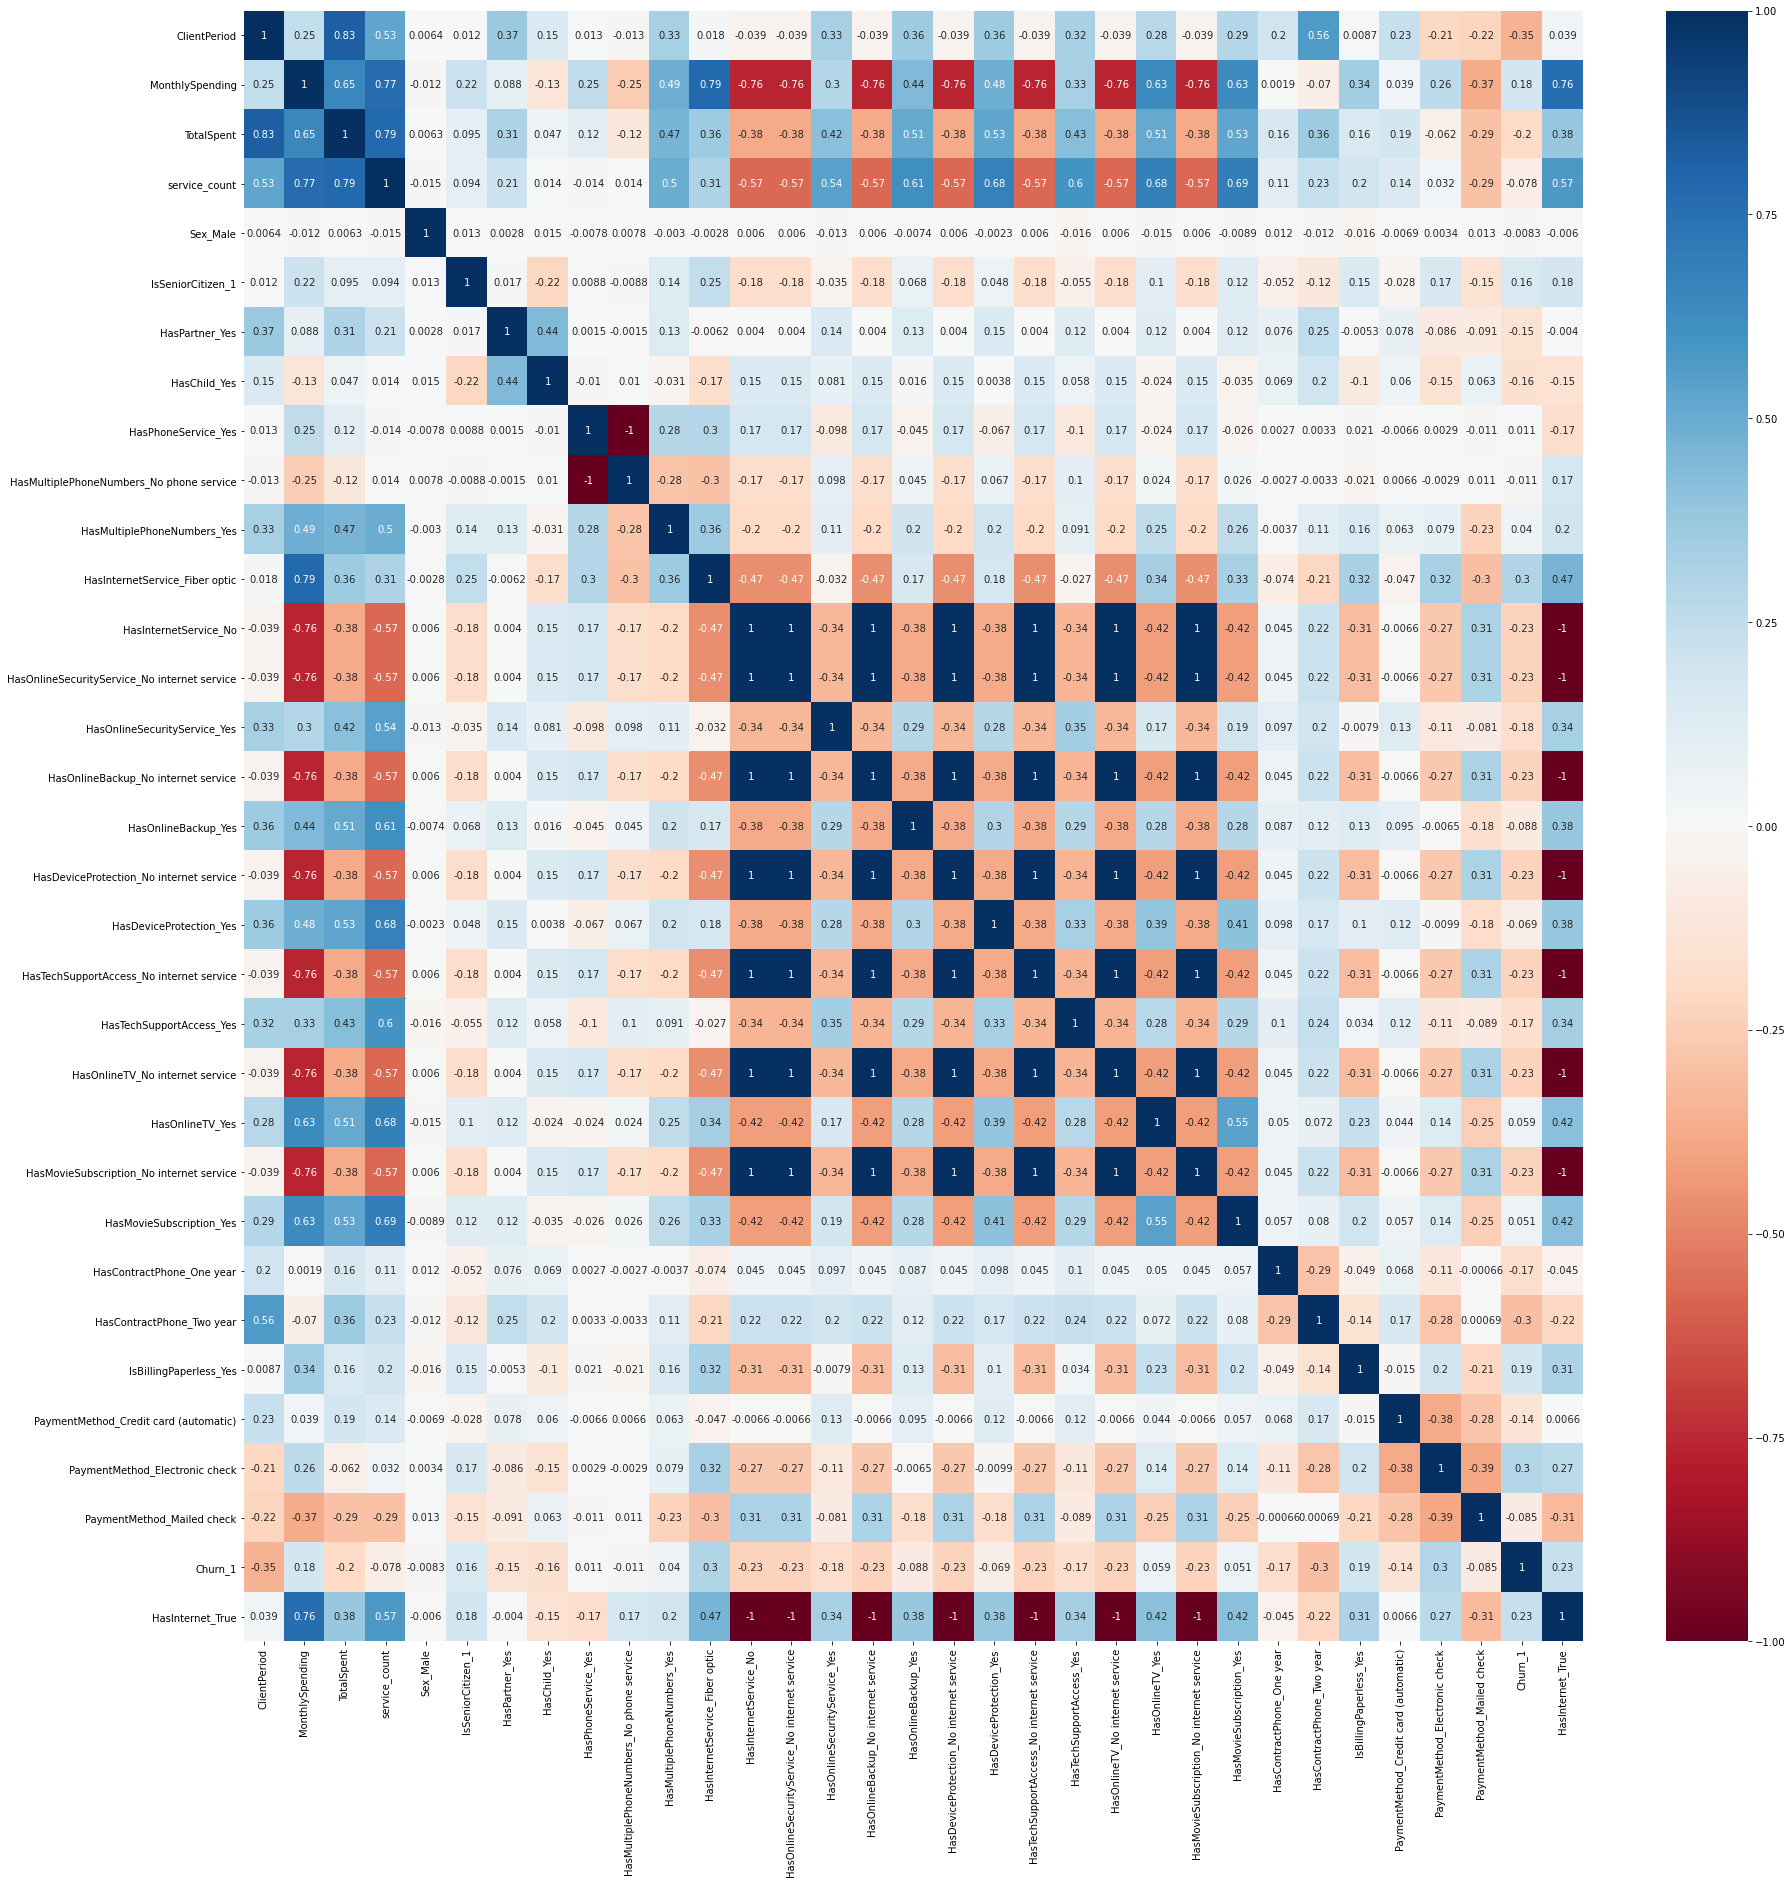

In [10]:
df = data.copy()
df = pd.get_dummies(df, drop_first=True) #one-hot encoding
colormap = plt.cm.RdBu
# матрица парных корреляций для отобранных данных
corr_m = df[list(df)].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_m, center=0, cmap=colormap, linecolor='white', annot=True)

#### Графики наиболее значимых корреляций


Коэффициент корреляции: 0.6520139189577207


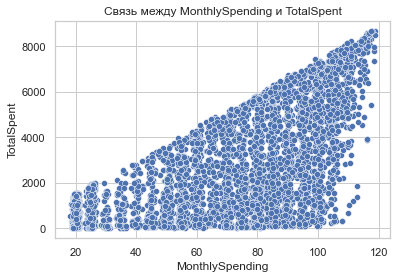


Коэффициент корреляции: 0.7724966155176803


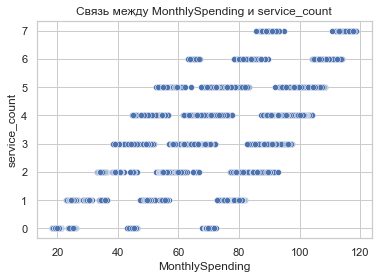


Коэффициент корреляции: 0.7887118987345869


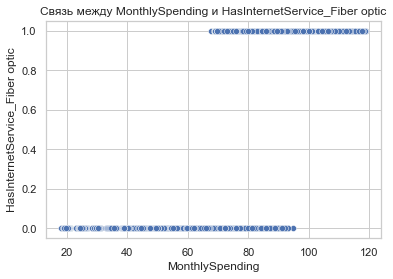


Коэффициент корреляции: 0.7617733556591234


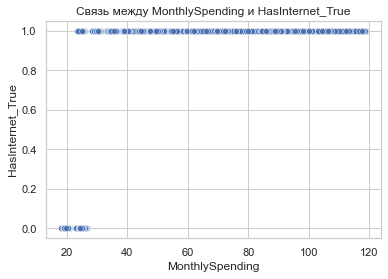

In [111]:
level = 0.65
for i in list(df):
    curr_corr = df[i].corr(df.MonthlySpending)
    if curr_corr >= level:
        if i != 'MonthlySpending':
            sns.scatterplot(x='MonthlySpending', y=i, data=df)
            print('\nКоэффициент корреляции: ' + str(curr_corr))
            plt.title('Связь между MonthlySpending и ' + str(i))
            plt.show()


Коэффициент корреляции: 0.8266579853802875


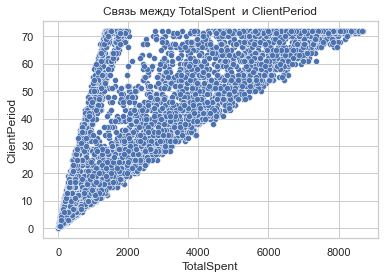


Коэффициент корреляции: 0.6520139189577207


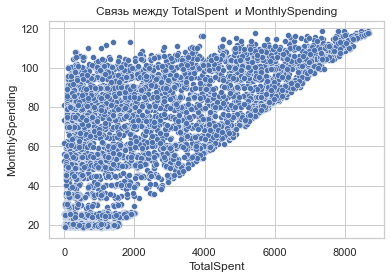


Коэффициент корреляции: 0.7881278425743314


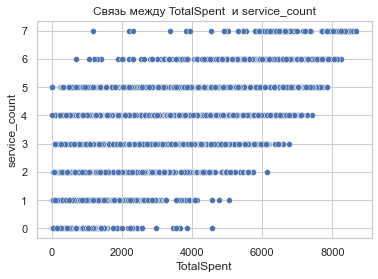

In [122]:
level = 0.6
for i in list(df):
    curr_corr = df[i].corr(df.TotalSpent )
    if curr_corr > level:
        if i != 'TotalSpent':
            sns.scatterplot(x='TotalSpent', y=i, data=df)
            print('\nКоэффициент корреляции: ' + str(curr_corr))
            plt.title('Связь между TotalSpent  и ' + str(i))
            plt.show()

# Выбор метрик, имеющих наиболее тесные взаимосвязи с целевой переменной.

## Метод 1. Оценка важности признаков с помощью SBS

In [15]:
# 'Жадная' функция последовательного обратного выбора признаков (SBS)
class SBS():
    def __init__(self, estimator, k_features,
                 scoring=roc_auc_score,
                 test_size=.2, random_state=42):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state, stratify=y)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test,
                    indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [16]:
# Перенос столбца c target 'Churn_1' в начало датасета для удобства
cols = df.columns.tolist()
df = df[['Churn_1'] +
        cols[:df.columns.get_loc('Churn_1')] + cols[df.columns.get_loc('Churn_1') + 1:]]
df = df.drop(['TotalSpent'], axis=1)

In [91]:
stdsc = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]],
                                                    df['Churn_1'], train_size=0.8, test_size=0.2,
                                                    shuffle=True, random_state=42, stratify=df['Churn_1'])
X_train_std = stdsc.fit_transform(x_train)
X_test_std = stdsc.transform(x_test)
print('Матрица Объекты X Фичи  (размерность): %s %s' %
      df[df.columns[1:]].shape)
print('Целевая переменная y (размерность): %s' % df['Churn_1'].shape)
print('\nМатрица Объекты X Фичи TRAIN (размерность): %s %s' % x_train.shape)
print('Целевая переменная y TRAIN (размерность): %s' % y_train.shape)
print('\nМатрица Объекты X Фичи  TEST (размерность): %s %s' % x_test.shape)
print('Целевая переменная y TEST (размерность): %s' % y_test.shape)

Матрица Объекты X Фичи  (размерность): 5282 31
Целевая переменная y (размерность): 5282

Матрица Объекты X Фичи TRAIN (размерность): 4225 31
Целевая переменная y TRAIN (размерность): 4225

Матрица Объекты X Фичи  TEST (размерность): 1057 31
Целевая переменная y TEST (размерность): 1057


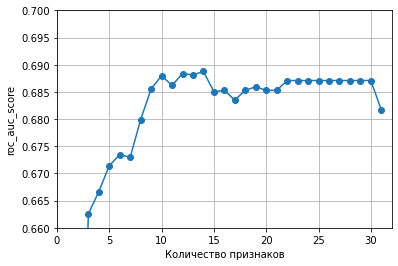

In [57]:
sbs_x = df[df.columns[1:]]
sbs_y = df['Churn_1']
sbs_x = stdsc.fit_transform(sbs_x)                 
clf = LogisticRegressionCV(scoring='roc_auc',random_state=42,refit=True)
sbs = SBS(clf, k_features=1)
sbs.fit(sbs_x, sbs_y)
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.66,0.7])
plt.xlim([0,32])
plt.ylabel('roc_auc_score')
plt.xlabel('Количество признаков')
plt.grid()
plt.show()

In [64]:
# Набор признаков, обеспечивающий максимальную эффективность на проверочном наборе данных
k = list(sbs.subsets_[14])
print('Отобранные фичи:', df.columns[1:][k])
clf.fit(X_train_std, y_train)
print('\nscore при обучении по всем фичам:', clf.score(X_train_std, y_train))
print('score при испытании по всем фичам:', clf.score(X_test_std, y_test))
clf.fit(X_train_std[:, k], y_train)
print('\nscore при обучении на отобранных фичах:',
      clf.score(X_train_std[:, k], y_train))
print('score при испытании на отобранных фичах:',
      clf.score(X_test_std[:, k], y_test))

Отобранные фичи: Index(['ClientPeriod', 'MonthlySpending', 'IsSeniorCitizen_1', 'HasChild_Yes',
       'HasPhoneService_Yes', 'HasMultiplePhoneNumbers_Yes',
       'HasInternetService_Fiber optic', 'HasInternetService_No',
       'HasOnlineBackup_Yes', 'HasDeviceProtection_Yes', 'HasOnlineTV_Yes',
       'HasMovieSubscription_Yes', 'HasContractPhone_One year',
       'HasContractPhone_Two year', 'IsBillingPaperless_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check'],
      dtype='object')

score при обучении по всем фичам: 0.8472920201888352
score при испытании по всем фичам: 0.8413433403558053

score при обучении на отобранных фичах: 0.8471865360438037
score при испытании на отобранных фичах: 0.8409190660112359


## Метод 2: оценка важности признаков с помощью случайных лесов

 1) ClientPeriod                             0.231635
 2) MonthlySpending                          0.203603
 3) service_count                            0.051234
 4) Sex_Male                                 0.038549
 5) IsSeniorCitizen_1                        0.036650
 6) HasPartner_Yes                           0.033711
 7) HasChild_Yes                             0.033657
 8) HasPhoneService_Yes                      0.030889
 9) HasMultiplePhoneNumbers_No phone service 0.030711
10) HasMultiplePhoneNumbers_Yes              0.028595
11) HasInternetService_Fiber optic           0.025371
12) HasInternetService_No                    0.025325
13) HasOnlineSecurityService_No internet service 0.025289
14) HasOnlineSecurityService_Yes             0.023672
15) HasOnlineBackup_No internet service      0.022491
16) HasOnlineBackup_Yes                      0.021129


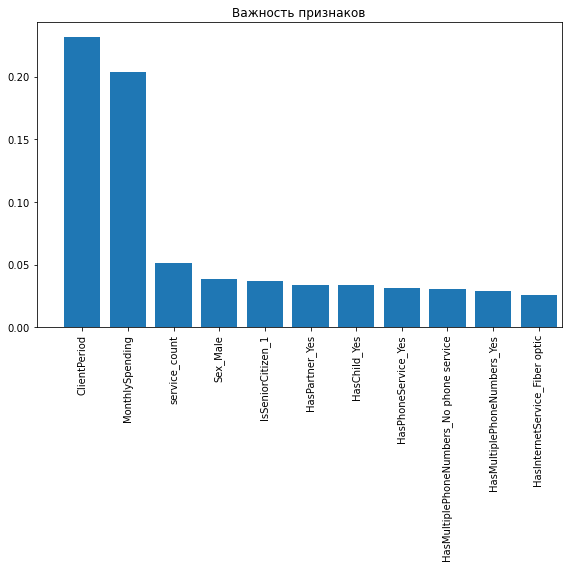

In [60]:
feat_labels = df.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=17)
forest.fit(x_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(x_train.shape[1]):
    if importances[indices[f]] > .021:
        print('%2d) %-*s %f' %
              (f+1, 40, feat_labels[f], importances[indices[f]]))
plt.figure(figsize=(8,8))
plt.title('Важность признаков')
plt.bar(range(x_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(x_train.shape[1]),
           feat_labels, rotation=90)
plt.xlim([-1, x_train.shape[1]-20.5])
plt.tight_layout()
plt.show()

## Метод 3: экстремальный градиентный бустинг XGBoost

[0]	test-auc:0.80716	train-auc:0.86158
[1]	test-auc:0.80953	train-auc:0.87101
[2]	test-auc:0.81163	train-auc:0.87167
[3]	test-auc:0.81158	train-auc:0.87462
[4]	test-auc:0.81597	train-auc:0.87623
[5]	test-auc:0.81513	train-auc:0.87702
[6]	test-auc:0.81530	train-auc:0.87776
[7]	test-auc:0.81560	train-auc:0.87907
[8]	test-auc:0.81643	train-auc:0.87959
[9]	test-auc:0.81604	train-auc:0.88064
[10]	test-auc:0.81581	train-auc:0.88137
[11]	test-auc:0.81622	train-auc:0.88246
[12]	test-auc:0.81605	train-auc:0.88326
[13]	test-auc:0.81498	train-auc:0.88407
[14]	test-auc:0.81472	train-auc:0.88543
[15]	test-auc:0.81465	train-auc:0.88684
[16]	test-auc:0.81375	train-auc:0.88780
[17]	test-auc:0.81443	train-auc:0.88904
[18]	test-auc:0.81498	train-auc:0.89057
[19]	test-auc:0.81428	train-auc:0.89180
[20]	test-auc:0.81444	train-auc:0.89229
[21]	test-auc:0.81393	train-auc:0.89319
[22]	test-auc:0.81416	train-auc:0.89408
[23]	test-auc:0.81384	train-auc:0.89516
[24]	test-auc:0.81425	train-auc:0.89572
[25]	test-

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

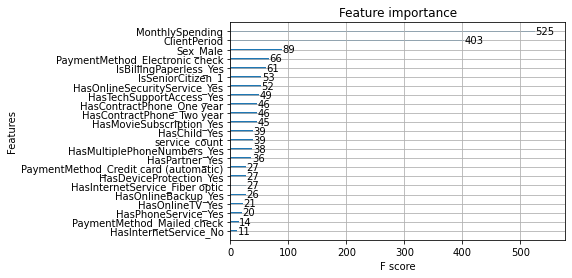

In [87]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 6,
          'eta': 0.1,
          'eval_metric': 'auc'}

num_rounds = 50

xgb_model = xgb.train(params, dtrain, num_rounds)

evals = [(dtest, 'test'), (dtrain, 'train')]
xgb_model = xgb.train(params, dtrain, num_rounds, evals)

xgb.plot_importance(xgb_model)

Выводы: все имеющиеся и сгенерированные признаки оказывают ненулевое влияние на целевую переменную. При этом признак TotalSpent желательно не учитывать при обучении модели для избавления от мультиколлинеарности.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [54]:
#подготовка датасета с учетом полученных данных.
#Исключим столбец TotalSpent
data_clean = data.drop(['TotalSpent'], axis=1).copy()
data_clean = pd.get_dummies(data_clean, drop_first=True) # one-hot-encoding

#перенос таргета на 1-ую позицию для удобства
cols = data_clean.columns.tolist()
data_clean = data_clean[['Churn_1'] +
        cols[:data_clean.columns.get_loc('Churn_1')] + cols[data_clean.columns.get_loc('Churn_1') + 1:]]

x_train, x_test, y_train, y_test = train_test_split(data_clean[data_clean.columns[1:]],
                                                    data_clean['Churn_1'], train_size=0.8, test_size=0.2,
                                                    shuffle=True, random_state=42, stratify=data_clean['Churn_1'])
#нормировка
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(x_train)
X_test_std = stdsc.transform(x_test)

In [55]:
#k-Fold кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

* ###### Logistic Regression CV (aka logit, MaxEnt) classifier.

In [13]:
my_array = np.logspace(-1, 2, num=500, endpoint=True)
clf = LogisticRegressionCV(
    Cs=my_array, cv=skf, multi_class='auto', scoring='roc_auc', 
    random_state=42, max_iter=1000, refit=True, penalty='l2')
lrc_model = clf.fit(X_train_std, y_train)
lrc_predictions = clf.predict(X_test_std)
print(f'LR_CV accuracy: {clf.score(X_test_std, y_test)}')
print(f'LR_CV f1_score: {f1_score(y_test, lrc_predictions)}')
print(f'LR_CV roc_auc_score: {roc_auc_score(y_test, lrc_predictions)}')
print(f'LR_CV cross_val_score: {cross_val_score(lrc_model, X_train_std, y_train, cv=skf, n_jobs=-1).mean(axis=0)}')

LR_CV accuracy: 0.8514903267610849
LR_CV f1_score: 0.5725806451612903
LR_CV roc_auc_score: 0.7069587151717115
LR_CV cross_val_score: 0.8399125379500589


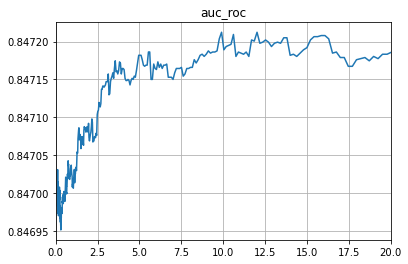

In [267]:
fig, ax = plt.subplots()
x = np.logspace(-1, 2, num=500, endpoint=True)
y = clf.scores_[1].mean(axis=0)
plt.plot(x, y)
plt.title('auc_roc')
ax.grid(True)
plt.xlim([0,20])
plt.show()

In [14]:
clf.C_ #лучшее значение C

array([0.10280732])

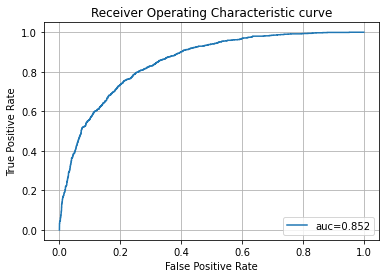

In [270]:
# вероятности принадлежности объектов тестовой выборки к классам
probas = clf.fit(X_train_std, y_train).predict_proba(X_train_std)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(round(auc,3)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.grid()
plt.show()

* ###### Логистическая регрессия (классический вариант)

In [15]:
lr_params = {'C': np.arange(0.1, 1, 0.1), 'multi_class': np.array(['auto', 'ovr', 'multinomial']),
             'solver': np.array(['newton-cg', 'lbfgs', 'sag', 'saga'])}
lr = LogisticRegression(random_state=42, **lr_params)
lr_gs = GridSearchCV(lr, lr_params, cv=skf)
lr_gs_model = lr_gs.fit(X_train_std, y_train)
lr_gs_predictions = lr_gs_model.predict(X_test_std)
lr_gs_accuracy = lr_gs.score(X_test_std, y_test)
print('LR best params:', lr_gs_model.best_params_)
print(f'LR accuracy: {lr_gs_accuracy}')
print(f'LR f1_score: {f1_score(y_test, lr_gs_predictions)}')
print(f'LR roc_auc_score: {roc_auc_score(y_test, lr_gs_predictions)}')
print(f'LR cross_val_score: {cross_val_score(lr_gs_model, X_train_std, y_train, cv=skf, n_jobs=-1).mean(axis=0)}')

LR best params: {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
LR accuracy: 0.7965941343424787
LR f1_score: 0.5691382765531062
LR roc_auc_score: 0.7050356382486347
LR cross_val_score: 0.8028402366863906


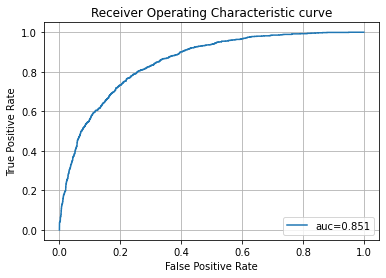

In [36]:
# вероятности принадлежности объектов тестовой выборки к классам
probas = lr_gs.fit(X_train_std, y_train).predict_proba(X_train_std)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(round(auc,3)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.grid()
plt.show()

* ###### Метод случайных лесов

In [56]:
rfc_params = {'n_estimators': range(10, 100, 10), 'min_samples_leaf': range(1, 8), 'max_depth': range(1, 13, 2)}
rfc = RandomForestClassifier(random_state=42, **rfc_params)
rfc_gs = GridSearchCV(rfc, rfc_params, cv=skf)
rfc_gs_model = rfc_gs.fit(X_train_std, y_train)
rfc_gs_predictions = rfc_gs_model.predict(X_test_std)
rfc_gs_accuracy = rfc_gs.score(X_test_std, y_test)
print('RFC best params:', rfc_gs_model.best_params_)
print(f'RFC accuracy: {rfc_gs_accuracy}')
print(f'RFC f1_score: {f1_score(y_test, rfc_gs_predictions)}')
print(f'RFC roc_auc_score: {roc_auc_score(y_test, rfc_gs_predictions)}')
print(f'RFC cross_val_score: {cross_val_score(rfc_gs_model, X_train_std, y_train, cv=skf, n_jobs=-1).mean(axis=0)}')

RFC best params: {'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 60}
RFC accuracy: 0.8107852412488175
RFC f1_score: 0.5708154506437769
RFC roc_auc_score: 0.7041747662686291
RFC cross_val_score: 0.8


**PIPE-LINE vs GRADIENTBOOSTING**
- Для того, чтобы от чего-то отталкиваться и понимать удалось ли улучшить модели, нам нужна какая-то отправная точка, Baseline.
- Будем использовать 7 моделей: Логистическую регрессию, К-ближайших соседей, Решающие деревья, Случайный лес, Метод опорных векторов(попробуем разные функции ядра), Наивный Байесовский классификатор, Градиентный бустинг.
- Объединим все модели стэкингом, для этого будем использовать StackingClassifier из sklearn
- Посчитаем метрики для базовых моделей.
    - Поскольку датасет несбалансирован, а для нас еще и recall очень важен, будем использовать следующие метрики: balanced accuracy, precision, recall, fbeta(с коэффициентом 2), roc-auc.

In [12]:
# Вспомогательные функции и классы.

# Функция для удобного представления оценок моделей
def model_score(model, X_test, y_test):
    name = ''
    scores = {}
    scores['balanced_accuracy'] = balanced_accuracy_score(y_test, model.predict(X_test))
    scores['precision'] = precision_score(y_test, model.predict(X_test))
    scores['recall'] = recall_score(y_test, model.predict(X_test))
    scores['fbeta'] = fbeta_score(y_test, model.predict(X_test), beta=2)
    if hasattr(model,'predict_proba'):
        scores['ROC_AUC'] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    else:
        scores['ROC_AUC'] = roc_auc_score(y_test, model.decision_function(X_test))
    if str(model).split('(')[0] == 'StackingClassifier':
        name = 'StackingClassifier'
    else:
        name = str(model.get_params()['steps'][-1][1]).split('(')[0]
    return pd.DataFrame(scores, index=[name])

In [5]:
# Чтобы во всех функциях, где используются генераторы псевдослучайных чисел у нас были одинаковые значения random_state
# заведем переменную RANDOM_STATE 
RANDOM_STATE = 42

num_features = [
    'ClientPeriod',
    'MonthlySpending',
    'service_count'
]

# Категориальные признаки
cat_features = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod',
    'HasInternet'
]

target_col = 'Churn'

X = data.drop(['Churn','TotalSpent'], axis=1)
y = data['Churn']

# Разделим выборку на тренировочную и тестовую части.
# Поскольку выборка несбалансирована, будем использовать стратификацию по y.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

# Создадим сплиттер для кросс-валидации при подборе гиперпараметров и для стэкинга.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [15]:
# Теперь соберем минимальный препроцессинг для датасета.
# Применим OrdinalEncoder к категориальным признакам.

minimal_prep = ColumnTransformer([
    ('cat', OrdinalEncoder(), cat_features),
    ('num', StandardScaler(), ['ClientPeriod', 'MonthlySpending', 'service_count'])
    ])

# Теперь создадим пайплайны для для базовых моделей.
# Логистическая регрессия
simple_lr = Pipeline(steps=[('preprocessing', minimal_prep),
                            ('classifier', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))])
# К-ближайших соседей
simple_knn = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', KNeighborsClassifier(n_jobs=-1))])
# Решающие деревья
simple_dtc = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))])
# Случайный лес
simple_rfc = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
# Метод опорных векторов (в дальнейшем попробуем разные функции ядра использовать, но пока по умолчанию rbf)
simple_svc = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', SVC(probability=True,random_state=RANDOM_STATE))])
# Байесовский классификатор
simple_nb = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', GaussianNB())])
# Градиентный бустинг
simple_xgb = Pipeline(steps=[('preprocessing', minimal_prep),
                             ('classifier', XGBClassifier(use_label_encoder=False,objective='binary:logistic',\
                                                          random_state=RANDOM_STATE, n_jobs=-1))])
simple_models_list = [('lr',simple_lr), ('knn',simple_knn), ('dtc',simple_dtc), ('rfc',simple_rfc),
                      ('svc',simple_svc), ('nb', simple_nb), ('xgb',simple_xgb)]
# Стэкинг

simple_stacking = StackingClassifier(estimators=simple_models_list, cv=skf, n_jobs=-1)

In [16]:
%%time
# Обучим модели и посчитаем базовые метрики.
scoring_list = [simple_lr, simple_knn, simple_dtc, simple_rfc, simple_svc, simple_nb, simple_xgb, simple_stacking]

simple_scores_df = pd.DataFrame()
for model in scoring_list:
    model.fit(X_train,y_train)
    simple_scores_df = simple_scores_df.append(model_score(model, X_test, y_test))

simple_scores_df.sort_values(by=['ROC_AUC','recall'], ascending=False)
simple_scores_df

[18:54:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 21.7 s, sys: 4.14 s, total: 25.8 s
Wall time: 22.3 s


,balanced_accuracy,precision,recall,fbeta,ROC_AUC
LogisticRegression,0.719136,0.663082,0.534682,0.556224,0.844012
KNeighborsClassifier,0.675875,0.574913,0.476879,0.493716,0.778802
DecisionTreeClassifier,0.652099,0.489736,0.482659,0.484058,0.652099
RandomForestClassifier,0.680025,0.621094,0.459538,0.484756,0.822686
SVC,0.674386,0.657778,0.427746,0.459913,0.794678
GaussianNB,0.757027,0.513410,0.774566,0.703043,0.829733
XGBClassifier,0.658534,0.556364,0.442197,0.461121,0.807495
StackingClassifier,0.715733,0.658273,0.528902,0.550542,0.843339


### Отберём топ-3 моделей и пересчитаем результат

In [17]:
%%time
simple_models_list = [('lr',simple_lr), ('rfc',simple_rfc)]
simple_stacking = StackingClassifier(estimators=simple_models_list, cv=skf, n_jobs=-1)

# Обучим модели и посчитаем базовые метрики.
scoring_list = [simple_lr, simple_rfc, simple_stacking]

simple_scores_df = pd.DataFrame()
for model in scoring_list:
    model.fit(X_train,y_train)
    simple_scores_df = simple_scores_df.append(model_score(model, X_test, y_test))

simple_scores_df.sort_values(by=['ROC_AUC','recall'], ascending=False)
simple_scores_df

CPU times: user 2.34 s, sys: 562 ms, total: 2.9 s
Wall time: 2.74 s


,balanced_accuracy,precision,recall,fbeta,ROC_AUC
LogisticRegression,0.719136,0.663082,0.534682,0.556224,0.844012
RandomForestClassifier,0.680025,0.621094,0.459538,0.484756,0.822686
StackingClassifier,0.707762,0.665399,0.505780,0.531269,0.845918


### Лучшее качество по Roc-Auc превышает 0.84 и принадлежит логистической модели, а также стекингу по линейной регресии и случайному лесу

**Теперь постараемся улучшить наши модели.**
1. Соберем пайплайн препроцессинга
2. Проведём оверсэмплинг
3. Проведём понижение размерности.
4. Прогоним пайплайны через GridSearch, подбирая параметры моделей и варианты препроцессинга.

In [36]:
# Создадим пайплан препроцессинга.
# Обработка числовых признаков.
num_prep = Pipeline([
                    ('scale', StandardScaler())
                    ])

# Обработка категориальных признаков
cat_prep = Pipeline([
                    ('encoding', OrdinalEncoder())
                    ])
# Собираем препроцессинг вместе
preprocessing = ColumnTransformer([
                         ('num', num_prep, ['ClientPeriod', 'MonthlySpending', 'service_count']),
                         ('cat', cat_prep, cat_features)
])

full_preprocessing = FeatureUnion([
                                 ('prep', preprocessing)
                                 ])

# Тестовый пайплайн
test_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', LogisticRegression())
                        ])

In [37]:
# Создадим полные пайплайны для всех 7 моделей.
# Логистическая регрессия
lr_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', LogisticRegression(random_state=RANDOM_STATE, max_iter=200,
                                                       class_weight='balanced', n_jobs=-1))
                        ])

# К-ближайших соседей
knn_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', KNeighborsClassifier(n_jobs=-1))
                        ])

# Решающие деревья
dtc_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
                        ])

# Случайный лес
rfc_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'))
                        ])

# Метод опорных векторов
svc_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', SVC(random_state=RANDOM_STATE, class_weight='balanced'))
                        ])

# Байесовский классификатор
nb_pipe = test_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', GaussianNB())
                        ])

# Градиентный бустинг
xgb_pipe = imbPipeline([
                        ('prep', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('classif', XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1))
                        ])

##### Зададим начальные гиперпараметры моделям

In [38]:
# Логистическая регрессия
final_lr_params = {
      'select__k': 17,
      'sampling': SMOTE(random_state=RANDOM_STATE),
      'classif__penalty': 'l1',
      'classif__C': 0.7,
      'classif__solver': 'liblinear',      
}

# К-ближайших соседей
final_knn_params = {
      'select__k': 7,
      'sampling': SMOTEENN(random_state=RANDOM_STATE),
      'classif__n_neighbors': 9,
      'classif__algorithm': 'ball_tree',
      'classif__weights': 'uniform',      
}

# Решающие деревья
final_dtc_params = {
      'select__k': 3,
      'sampling': SMOTE(random_state=RANDOM_STATE),
      'classif__criterion': 'gini',
      'classif__splitter': 'best',
      'classif__max_features': 'sqrt',
      'classif__min_samples_leaf': 251,

}

# Случайный лес
final_rfc_params = {
      'select__k': 'all',
      'sampling': SMOTEENN(random_state=RANDOM_STATE),
      'classif__n_estimators': 100,
      'classif__criterion': 'entropy',
      'classif__max_features': 'sqrt',
      'classif__min_samples_leaf': 11,

}

# Метод опорных векторов
final_svc_params = {
      'select__k': 'all',
      'sampling': SMOTEENN(random_state=RANDOM_STATE),
      'classif__C': 0.6,
      'classif__kernel': 'linear'
}

# Байесовский классификатор
final_nb_params = {
      'select__k': 10,
      'sampling': SMOTEENN(random_state=RANDOM_STATE)
}


# Градиентный бустинг
final_xgb_params = {
      'select__k': 'all',
      'sampling': SMOTEENN(random_state=RANDOM_STATE),
      'classif__n_estimators': 100,
      'classif__learning_rate': 0.1
}

In [40]:
final_lr = lr_pipe.set_params(**final_lr_params)
final_knn = knn_pipe.set_params(**final_knn_params)
final_dtc = dtc_pipe.set_params(**final_dtc_params)
final_rfc = rfc_pipe.set_params(**final_rfc_params)
final_svc = svc_pipe.set_params(**final_svc_params)
final_nb = nb_pipe.set_params(**final_nb_params)
final_xgb = xgb_pipe.set_params(**final_xgb_params)

In [41]:
%%time
## Теперь попробуем найти лучшие гиперпараметры для финального алгоритма в StackingClassifier
## В данном случае для логистической регрессии.
stacking_list = [('lr',final_lr), ('knn',final_knn), ('dtc',final_dtc),
                  ('rfc',final_rfc), ('svc', final_svc), ('nb', final_nb),
                  ('xgb', final_xgb)]
final_stacking = StackingClassifier(estimators=stacking_list,
                                    final_estimator = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
                                    cv=skf, n_jobs=-1)
fs_grid = {'final_estimator__penalty': ['l1','l2','elasticnet'],
      'final_estimator__C': np.arange(0.1,1.1,0.1),
      'final_estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}  
fsgs = GridSearchCV(estimator=final_stacking, param_grid=fs_grid, cv=5, n_jobs=-1, scoring='roc_auc')
fsgs.fit(X_train, y_train)
print('Best params fo Stacking')
print(fsgs.best_params_)

Best params fo Stacking
{'final_estimator__C': 0.7000000000000001, 'final_estimator__penalty': 'l1', 'final_estimator__solver': 'liblinear'}
CPU times: user 17.4 s, sys: 922 ms, total: 18.4 s
Wall time: 1h 26min


In [42]:
# Модель финального стэкинга с лучшими параметрами.
final_stacking = StackingClassifier(estimators=stacking_list,
                                    final_estimator = LogisticRegression(penalty = 'l1',
                                                                         C = 0.7, solver = 'liblinear',
                                                                         random_state=RANDOM_STATE, n_jobs=-1),
                                    cv=skf, n_jobs=-1)

In [43]:
# Список всех итоговых моделей с подобранными гиперпараметрами
final_models_list = [final_lr, final_knn, final_dtc, final_rfc, final_svc, final_nb, final_xgb, final_stacking]

# Сравнение качества моделей 

In [44]:
scoring_list = [simple_lr, simple_knn, simple_dtc, simple_rfc, simple_svc, simple_nb, simple_xgb, simple_stacking]

simple_scores_df = pd.DataFrame()
for model in scoring_list:
    simple_scores_df = simple_scores_df.append(model_score(model, X_test, y_test))
print('Базовые метрики, до подбора вариантов препроцессинга и гиперпараметров моделей')
simple_scores_df

Базовые метрики, до подбора вариантов препроцессинга и гиперпараметров моделей


,balanced_accuracy,precision,recall,fbeta,ROC_AUC
LogisticRegression,0.719136,0.663082,0.534682,0.556224,0.844012
KNeighborsClassifier,0.675875,0.574913,0.476879,0.493716,0.778802
DecisionTreeClassifier,0.652099,0.489736,0.482659,0.484058,0.652099
RandomForestClassifier,0.680025,0.621094,0.459538,0.484756,0.822686
SVC,0.674386,0.657778,0.427746,0.459913,0.794678
GaussianNB,0.757027,0.513410,0.774566,0.703043,0.829733
XGBClassifier,0.658534,0.556364,0.442197,0.461121,0.807495
StackingClassifier,0.707762,0.665399,0.505780,0.531269,0.845918


In [74]:
final_scores = pd.DataFrame()
for model in final_models_list:
    model.fit(X_train, y_train)
    final_scores = final_scores.append(model_score(model, X_test, y_test))
print('\033[1m' + '\nФинальные оценки')
# full_scores.sort_values(by=['ROC_AUC','recall'], ascending=False)
final_scores

[21:03:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Финальные оценки


,balanced_accuracy,precision,recall,fbeta,ROC_AUC
LogisticRegression,0.758333,0.521654,0.765896,0.700317,0.840663
KNeighborsClassifier,0.756603,0.465116,0.867052,0.739280,0.816880
DecisionTreeClassifier,0.734924,0.429972,0.887283,0.731649,0.748422
RandomForestClassifier,0.770545,0.522642,0.800578,0.723615,0.845878
SVC,0.761733,0.487352,0.835260,0.730905,0.840159
GaussianNB,0.758284,0.492147,0.815029,0.720491,0.832758
XGBClassifier,0.767051,0.539715,0.765896,0.706667,0.844744
StackingClassifier,0.729297,0.645902,0.569364,0.583185,0.846102


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

### Выводы: получены значительные улучшения метрик по всем моделям. Более чем у 50% моделей параметр ROC_AUC превышает порог 0.84, что является максимальной оценкой данной работы.

## Применение градиентного бустинга CatBoost (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [14]:
import catboost

dat = data.copy()

dat[cat_features] = dat[cat_features].astype('object')
dat[target_col] = dat[target_col].astype('object')
dat = dat.drop(['TotalSpent'], axis=1)

X_origin = dat.drop(['Churn'], axis=1)
y = dat['Churn']
categorical_indices = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19])

In [15]:
X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.8, shuffle = True,
                                                       random_state=42, stratify=y.values)

In [16]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200,  learning_rate=.01, depth=7,
                                             cat_features=categorical_indices,
                                             l2_leaf_reg = 5,
                                             eval_metric='AUC:hints=skip_train~false')

boosting_model.fit(X_train_origin, y_train_origin)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

0:	learn: 0.8250341	total: 66.5ms	remaining: 13.2s
1:	learn: 0.8242622	total: 70.5ms	remaining: 6.98s
2:	learn: 0.8312781	total: 80.2ms	remaining: 5.27s
3:	learn: 0.8333868	total: 90.7ms	remaining: 4.45s
4:	learn: 0.8337597	total: 101ms	remaining: 3.95s
5:	learn: 0.8363754	total: 112ms	remaining: 3.63s
6:	learn: 0.8347854	total: 123ms	remaining: 3.39s
7:	learn: 0.8346252	total: 130ms	remaining: 3.13s
8:	learn: 0.8362014	total: 141ms	remaining: 2.98s
9:	learn: 0.8380395	total: 152ms	remaining: 2.89s
10:	learn: 0.8386610	total: 165ms	remaining: 2.84s
11:	learn: 0.8383770	total: 170ms	remaining: 2.66s
12:	learn: 0.8385910	total: 180ms	remaining: 2.59s
13:	learn: 0.8383585	total: 193ms	remaining: 2.57s
14:	learn: 0.8380313	total: 203ms	remaining: 2.5s
15:	learn: 0.8380763	total: 210ms	remaining: 2.42s
16:	learn: 0.8378198	total: 219ms	remaining: 2.36s
17:	learn: 0.8394642	total: 230ms	remaining: 2.33s
18:	learn: 0.8395676	total: 238ms	remaining: 2.27s
19:	learn: 0.8399650	total: 247ms	rema

160:	learn: 0.8602838	total: 1.46s	remaining: 355ms
161:	learn: 0.8603832	total: 1.47s	remaining: 346ms
162:	learn: 0.8603632	total: 1.48s	remaining: 336ms
163:	learn: 0.8605588	total: 1.49s	remaining: 327ms
164:	learn: 0.8606202	total: 1.5s	remaining: 318ms
165:	learn: 0.8607384	total: 1.51s	remaining: 310ms
166:	learn: 0.8607439	total: 1.52s	remaining: 301ms
167:	learn: 0.8610122	total: 1.53s	remaining: 292ms
168:	learn: 0.8610917	total: 1.54s	remaining: 282ms
169:	learn: 0.8610384	total: 1.54s	remaining: 272ms
170:	learn: 0.8611282	total: 1.55s	remaining: 263ms
171:	learn: 0.8612279	total: 1.56s	remaining: 254ms
172:	learn: 0.8612270	total: 1.56s	remaining: 244ms
173:	learn: 0.8612983	total: 1.57s	remaining: 235ms
174:	learn: 0.8612844	total: 1.58s	remaining: 225ms
175:	learn: 0.8613756	total: 1.59s	remaining: 216ms
176:	learn: 0.8615141	total: 1.6s	remaining: 207ms
177:	learn: 0.8615141	total: 1.6s	remaining: 198ms
178:	learn: 0.8615048	total: 1.6s	remaining: 188ms
179:	learn: 0.86

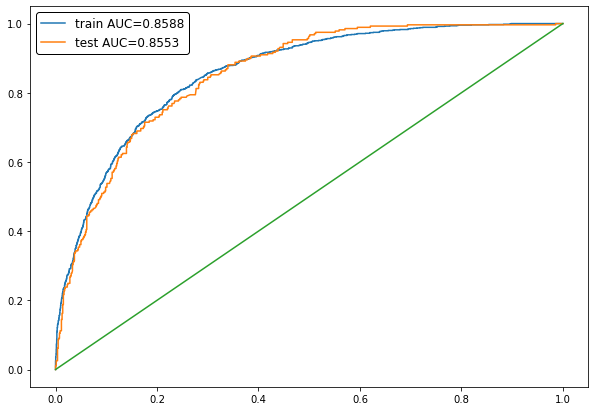

In [126]:
train_auc = roc_auc_score(y_train_origin, y_train_predicted)
test_auc = roc_auc_score(y_test_origin, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_origin, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test_origin, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
boosting_model = catboost.CatBoostClassifier(silent=True, #n_estimators=200
                                             cat_features=categorical_indices,
                                             eval_metric='AUC:hints=skip_train~false')

gs_result = boosting_model.grid_search({'l2_leaf_reg': np.linspace(1, 10, 10),
                           'learning_rate': np.arange(0.01, 0.21, 0.03),
                           'depth': [2, 4, 6, 8],
                           'iterations':np.arange(500, 1100, 100)},
                           X_train_origin, 
                           y_train_origin, plot=True, refit=True)

### Полученные лучшие параметры

In [31]:
gs_result['params']

{'depth': 2, 'l2_leaf_reg': 9, 'iterations': 300, 'learning_rate': 0.13}

In [ ]:
boosting_model = catboost.CatBoostClassifier(verbose = False, cat_features=categorical_indices, eval_metric='AUC:hints=skip_train~false', 
                                         l2_leaf_reg = 9, min_data_in_leaf = 88, iterations = 300, learning_rate = 0.13, depth = 2)
boosting_model.fit(X_train_origin, y_train_origin)

# Выгрузка в Kaggle single-моделей

In [24]:
stdsc = StandardScaler()
num_cols_kaggle = ['ClientPeriod','MonthlySpending']
cat_cols_kaggle = ['Sex','IsSeniorCitizen','HasPartner','HasChild','HasPhoneService','HasMultiplePhoneNumbers',
    'HasInternetService','HasOnlineSecurityService','HasOnlineBackup','HasDeviceProtection','HasTechSupportAccess',
    'HasOnlineTV','HasMovieSubscription','HasContractPhone','IsBillingPaperless','PaymentMethod']
service_list = ['HasMultiplePhoneNumbers','HasOnlineSecurityService','HasOnlineBackup',
                'HasDeviceProtection','HasTechSupportAccess','HasOnlineTV','HasMovieSubscription']


X_test_kaggle = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')
X_test_kaggle = X_test_kaggle.drop(['TotalSpent'], axis=1).copy()
X_test_kaggle[cat_cols_kaggle] = X_test_kaggle[cat_cols_kaggle].astype('category')
X_test_kaggle[num_cols_kaggle] = X_test_kaggle[num_cols_kaggle].astype('float')
X_test_kaggle['service_count'] = X_test_kaggle[service_list]\
                              .applymap(lambda x: 0 if x in ('No phone service', 'No internet service','No') else 1)\
                              .sum(axis=1)
X_test_kaggle['HasInternet'] = (X_test_kaggle['HasInternetService'] != 'No').astype('category')
X_test_kaggle = pd.get_dummies(X_test_kaggle, drop_first=True)
X_test_kaggle_std = stdsc.fit_transform(X_test_kaggle)

In [57]:
best_model = rfc_gs_model

submission['Churn'] = best_model.predict_proba(X_test_kaggle_std)[:,-1:]

submission.to_csv('./my_submission.csv', index=False)

# Выгрузка  в Kaggle pipe-line моделей

In [68]:
X_test_kaggle = pd.read_csv('./test.csv')
X_test_kaggle = X_test_kaggle.drop(['TotalSpent'], axis=1).copy()
X_test_kaggle['service_count'] = X_test_kaggle[service_list]\
                              .applymap(lambda x: 0 if x in ('No phone service', 'No internet service','No') else 1)\
                              .sum(axis=1)
X_test_kaggle['HasInternet'] = (X_test_kaggle['HasInternetService'] != 'No').astype('category')

In [70]:
best_model = final_rfc
submission = pd.read_csv('./submission.csv')
submission['Churn'] = best_model.predict_proba(X_test_kaggle)[:,-1:]
submission.to_csv('./my_submission.csv', index=False)

In [67]:
best_model = simple_rfc
submission = pd.read_csv('./submission.csv')
submission['Churn'] = best_model.predict_proba(X_test_kaggle)[:,-1:]
submission.to_csv('./my_submission.csv', index=False)

# Выгрузка  в Kaggle CatBoost

In [26]:
#Kaggle-submit for CatBoost
best_model = boosting_model

X_test_kaggle_boosting = pd.read_csv('./test.csv')
X_test_kaggle_boosting = X_test_kaggle_boosting.drop(['TotalSpent'], axis=1)
X_test_kaggle_boosting[num_cols_kaggle] = X_test_kaggle_boosting[num_cols_kaggle].astype('float')
X_test_kaggle_boosting[cat_cols_kaggle] = X_test_kaggle_boosting[cat_cols_kaggle].astype('object')
X_test_kaggle_boosting['service_count'] = X_test_kaggle_boosting[service_list]\
                              .applymap(lambda x: 0 if x in ('No phone service', 'No internet service','No') else 1)\
                              .sum(axis=1)
X_test_kaggle_boosting['HasInternet'] = (X_test_kaggle_boosting['HasInternetService'] != 'No').astype('category')
submission['Churn'] = best_model.predict_proba(X_test_kaggle_boosting)[:,-1:]
submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов

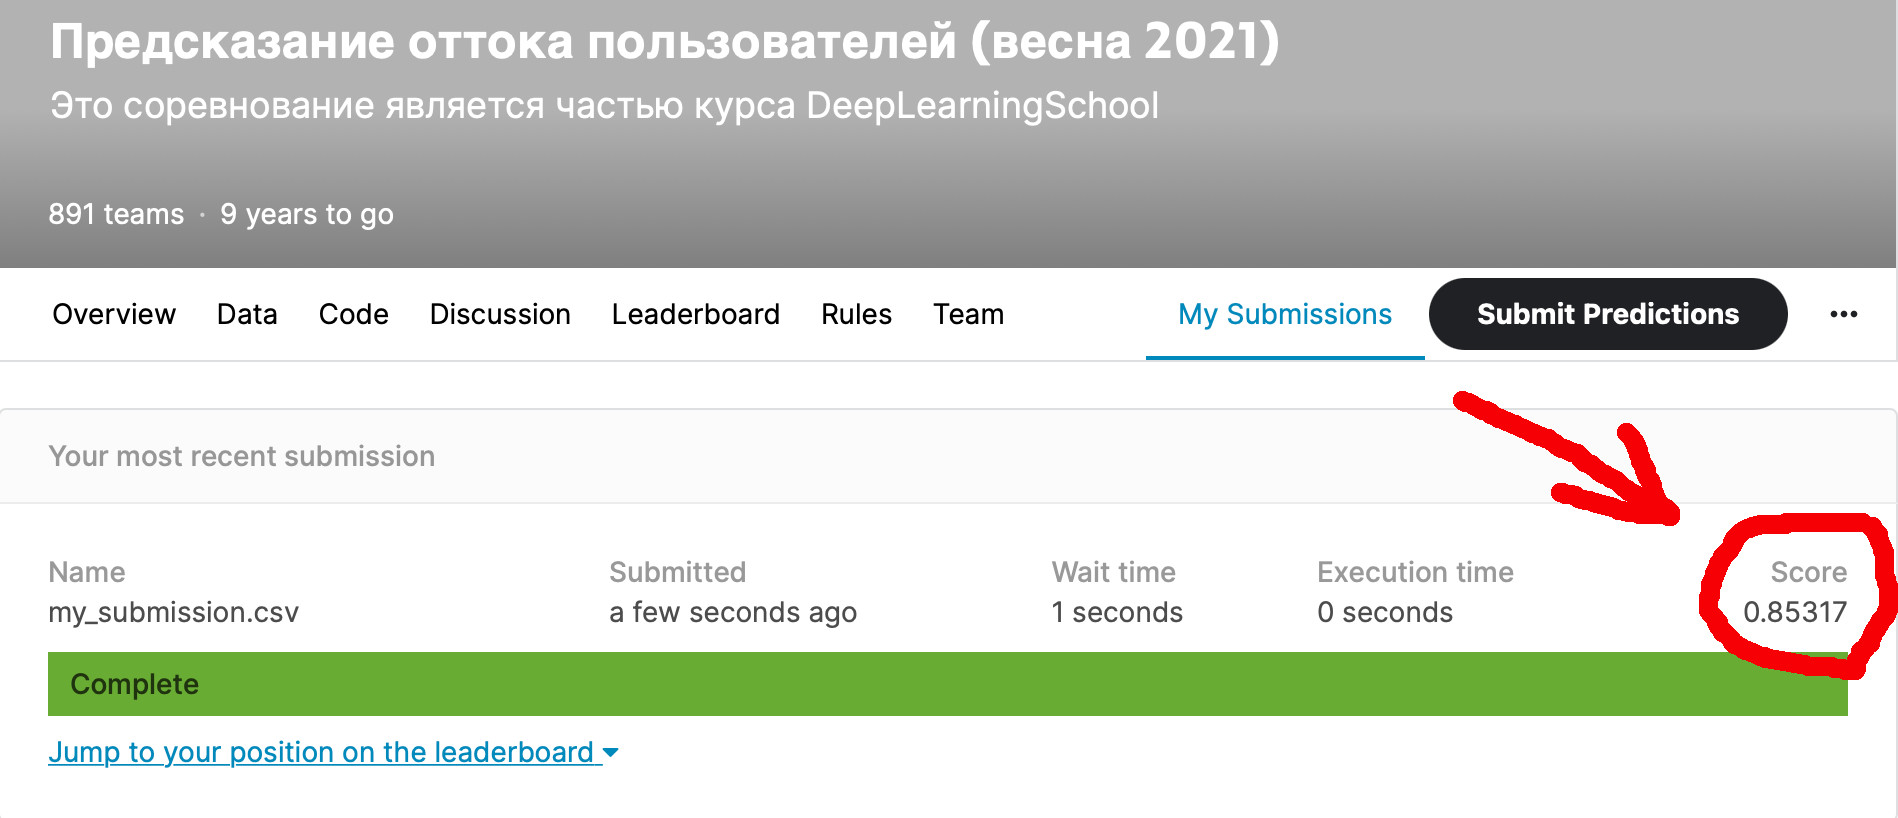

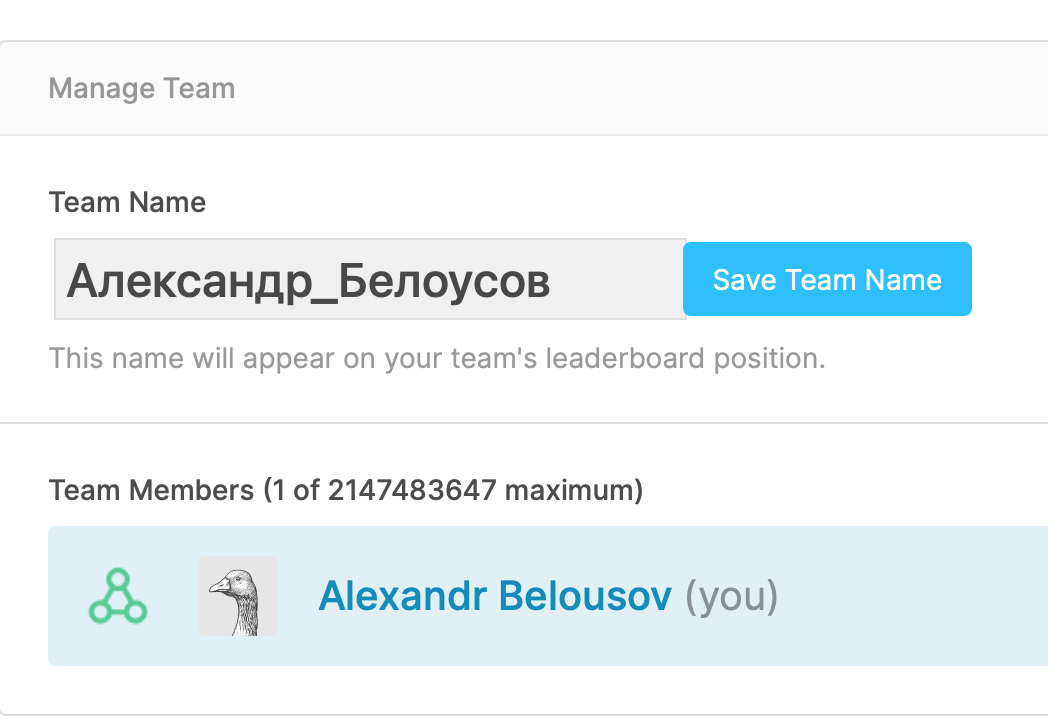